[0.788074   1.19306772 1.44965489 1.47066239 0.5058695  0.61665083
 0.7956758  0.29625593 1.0032851  0.35219537 0.77953654 1.15673026
 1.14914121 1.42932101 1.36988302]
Timestep:  0.0 seconds
Timestep:  10.0 seconds
Timestep:  20.0 seconds
Timestep:  30.0 seconds
216.08734703063965


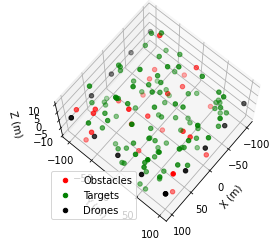

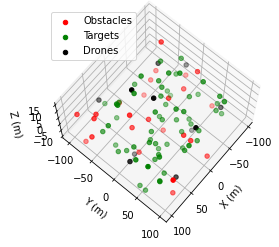

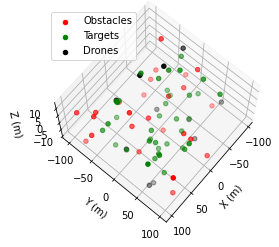

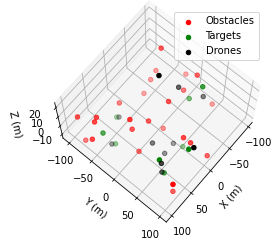

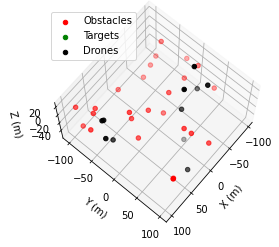

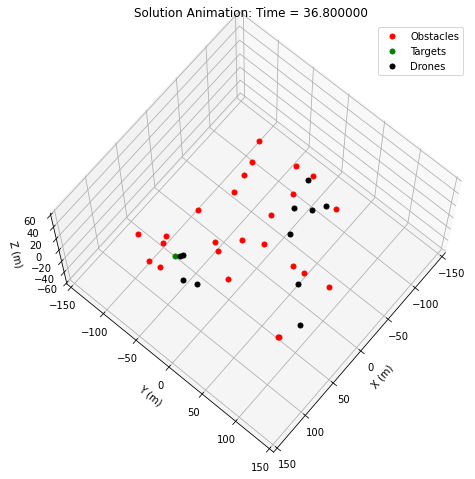

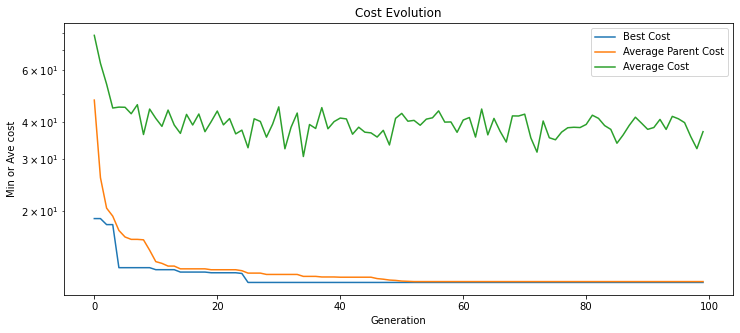

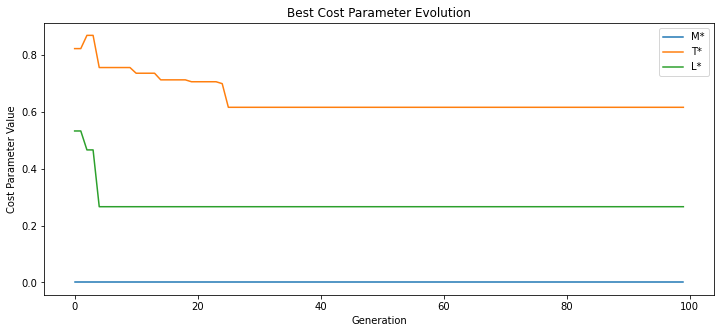

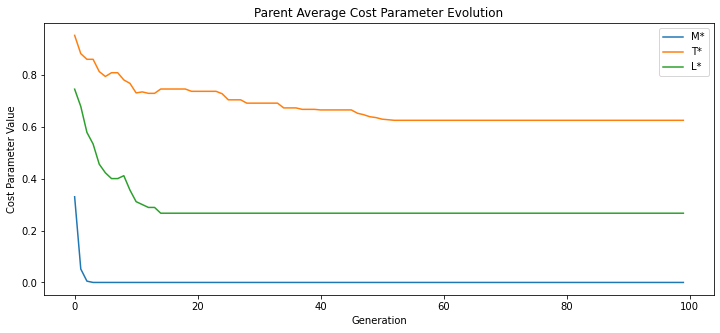

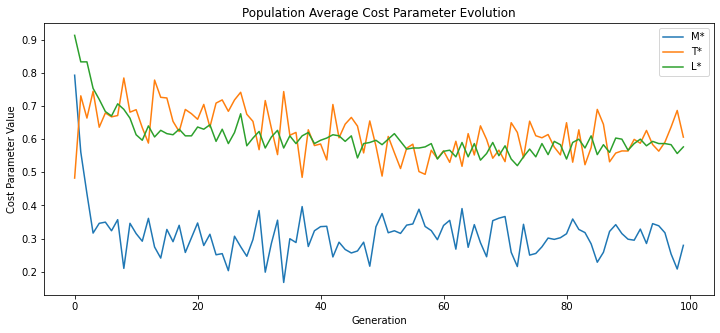

In [1]:

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
from matplotlib import animation
from matplotlib import rc
import time

#plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
#plt.rcParams['animation.ffmpeg_path'] = '/Users/keonetebari/Downloads'
################################## Defining Project Constants ##################################

# The drones are referred to as agents

# System Parameters
Nm = 15                                         # number of initial agents
No = 25                                         # number of obstacles
Nt = 100                                        # number of targets to map

# Physical Parameters
Ai = 1                                          # agent characteristic area (m^2)
Cdi = 0.25                                      # agent coefficient of drag
mi = 10                                         # agent mass (kg)
va = [-0.2, 0.2, 0.5]                           # Air velocity (m/s)
ra = 1.225                                      # Air Density (kg/m^3)
Fp = 200                                        # Propulsion force magnitude (N)

# Time Stepping Parameters
dt = 0.2                                        # time step size (s)
tf = 60                                         # Maximum task time (s)

# Object Interaction Parameters
agent_sight = 5                                 # maximum target mapping distance
crash_range = 2                                 # agent collision distance

# Genetic Algorithm Parameters
K = 6                                           # Strings generated by breeding
P = 6                                           # Surviving strings for breeding
S = 20                                          # Design strings per generation
G = 100                                         # Total Generations
minLam = 0.                                     # Minimum value of design strings
maxLam = 2.                                     # Maximum value of design strings
numLam = 15

w1 = 70                                         # Weight of mapping in net cost
w2 = 10                                         # Weight of time usage in net cost
w3 = 20                                         # Weight of agent losses in net cost

# Domain Parameters
xmax = 150                                      # x bound of domain
ymax = 150                                      # y bound of domain
zmax = 60                                       # z bound of domain

locx = 100                                      # x bound of target/obstacle region
locy = 100                                      # y bound of target/obstacle region
locz = 10                                       # z bound of target/obstacle region

# Initialize Obstacle Locations
obs = np.array([(locx - (-locx))*np.random.rand(No) + (-locx),
                (locy - (-locy))*np.random.rand(No) + (-locy),
                (locz - (-locz))*np.random.rand(No) + (-locz)])
obs = obs.T

# Initial Target Locations
tar = np.array([(locx - (-locx))*np.random.rand(Nt) + (-locx),
                (locy - (-locy))*np.random.rand(Nt) + (-locy),
                (locz - (-locz))*np.random.rand(Nt) + (-locz)])
tar = tar.T

# Initialize drone positions and velocity
pos = np.zeros((Nm,3))
row = np.linspace(-100,100,5)
for i in range(len(pos)):
    if i < 5:
        pos[i][0] = row[i]
        pos[i][1] = 100
        pos[i][2] = 1
    elif i >= 5 and i < 10:
        pos[i][1] = row[i-5]
        pos[i][0] = 100
        pos[i][2] = 1
    else:
        pos[i][1] = -100
        pos[i][0] = row[i - 10]
        pos[i][2] = 1

vel = np.zeros([Nm, 3])

pos0 = pos                              # Initial agent positions
vel0 = vel                              # Initial agent velocities
tar0 = tar                              # Initial target positions

################################## Plotting Initial System ####################################################




################################## Drone Simulation Function ####################################################

def droneSim(nM, nO, nT, w1, w2, w3, LAM, dt, tf, posM, velM, posTar, posObs,plots = False):
    """
    Run the simulation on a swarm of drone given a set of parameters
    :param nA: Number of agents
    :param nO: Number of obstacles
    :param nT: Number of Targets
    :param w1: Weight of mapping in net cost
    :param w2: Weight of time usage in net cost
    :param w3: Weight of agent losses in net cost
    :param LAM: Interaction parameters to be optimized:
                Wmt: Equation 23
                Wmo: Equation 23
                Wmm: Equation 23
                wt1: Equation 13
                wt2: Equation 13
                wo1: Equation 17
                wo2: Equation 17
                wm1: Equation 21
                wm2: Equation 21
                a1: Equation 13
                a2: Equation 13
                b1: Equation 17
                b2: Equation 17
                c1: Equation 21
                c2: Equation 21
    :param dt: Time step
    :param tf: Final time
    :param pos: initial position vector of all drones
    :param vel: initial velocity vector of all drones
    :param tar: position of all targets
    :param obs: position of all obstacles

    :return: Cost function value (scalar),
             Drone position data (nM, 3),
             Target position data (nT, 3),
             counter (scalar),
             Mstar (scalar),
             Tstar (scalar),
             Lstar (scalar)
    """

    Nt0 = nT  # Saving initial number of targets for cost calculation
    Nm0 = nM  # Saving initial number of agents for cost calculation

    # Assigning design string to associated variables
    Wmt = LAM[0]
    Wmo = LAM[1]
    Wmm = LAM[2]
    wt1 = LAM[3]
    wt2 = LAM[4]
    wo1 = LAM[5]
    wo2 = LAM[6]
    wm1 = LAM[7]
    wm2 = LAM[8]
    a1 = LAM[9]
    a2 = LAM[10]
    b1 = LAM[11]
    b2 = LAM[12]
    c1 = LAM[13]
    c2 = LAM[14]

    tStep = int(np.ceil(tf / dt))                       # total time steps
    counter = 0                                         # counter for actual number of time steps
    posData = []                                        # store mPosition data
    tarData = []                                        # store mTarget data
    posData.append(posM)
    tarData.append(posTar)
    plotT = np.linspace(0,40,5)
    # step through time
    for i in range(tStep):
        if(plots):
            if(np.isin(i*dt, plotT)):
                print("Timestep: ",i*dt, "seconds" )
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(posObs[:, 0], posObs[:, 1], posObs[:, 2], color='r')
                ax.scatter(posTar[:, 0], posTar[:, 1], posTar[:, 2], color='g')
                ax.scatter(posM[:, 0], posM[:, 1], posM[:, 2], color='k')
                ax.set_xlabel('X (m)')
                ax.set_ylabel('Y (m)')
                ax.set_zlabel('Z (m)')
                ax.view_init(elev=70., azim=40)
                ax.legend(['Obstacles', 'Targets', 'Drones'])

        #####################################################################
        # check for crashes, lost agents, targets achieved, etc.
        # nM = 15   # |   none  | SCALAR - Number of initial agents
        # nO = 25   # |   none  | SCALAR - Number of obstacles
        # nT = 100  # |   none  | SCALAR - Number of initial targets
        #####################################################################

        # compute differences between targets, agents and obstacles
        mtDiff = np.zeros((len(posM[:, 0]), len(posTar[:, 0]), 3))               # agent to target distance (nM, nT, 3)
        mmDiff = np.zeros((len(posM[:, 0]), len(posM[:, 0]), 3))                 # agent to agent distance (nM, nM, 3)
        moDiff = np.zeros((len(posM[:, 0]), len(posObs[:, 0]), 3))               # agent to obstacle distance (nM, nO, 3)

        # compute distances between targets, agents and obstacles
        mtDist = np.zeros((len(posM[:, 0]), len(posTar[:, 0])))                  # agent to target distance   (nM, nT)
        mmDist = np.zeros((len(posM[:, 0]), len(posM[:, 0])))                    # agent to agent distance    (nM, nM)
        moDist = np.zeros((len(posM[:, 0]), len(posObs[:, 0])))                  # agent to obstacle distance (nM, nO)

        # check each agent
        for j in range(len(posM[:, 0])):
            mtDiff[j, :, :] = (posTar - posM[j])                            # (nM x nT x 3)
            mmDiff[j, :, :] = (posM - posM[j])                              # (nM x nM x 3)
            moDiff[j, :, :] = (posObs - posM[j])                            # (nm x nO x 3)
            mmDiff[j, j, :] = np.nan

            mtDist[j, :] = np.linalg.norm(posM[j] - posTar, ord=2, axis=1)  # (nT x 3) --norm--> (nT x 1)
            mmDist[j, :] = np.linalg.norm(posM[j] - posM, ord=2, axis=1)    # (nM x 3)  --norm--> (nM x 1)
            moDist[j, :] = np.linalg.norm(posM[j] - posObs, ord=2, axis=1)  # (nO x 3)  --norm--> (nO x 1)

            # don't count distances of agents with themselves
            mmDist[j, j] = np.nan

        # check if agents are in the range of the targets, obstacles, agents, our boundaries
        mtHit = np.where(mtDist < agent_sight)                # return ij indices of m-t combos
        moHit = np.where(moDist < crash_range)                # return ij indices of m-o combos
        mmHit = np.where(mmDist < crash_range)                # return ij indices of m-m combos

        # check for lost agents
        xLost = np.where(np.abs(posM[:, 0]) > xmax)
        yLost = np.where(np.abs(posM[:, 1]) > ymax)
        zLost = np.where(np.abs(posM[:, 2]) > zmax)

        # return i indices of lost drones
        mLost = np.unique(np.hstack([xLost[0], yLost[0], zLost[0]]))

        # index all targets mapped
        tarMapped = np.unique(mtHit[1])                       # returns indices of m-t contact (j columns are targets)

        # index all agents crashed (from agent, obstacle and lost
        mCrash = np.unique(np.hstack([mmHit[0], moHit[0], mLost]))

        # remove crashed agents
        posM = np.delete(posM, (mCrash), axis=0)
        velM = np.delete(velM, (mCrash), axis=0)
        nT = nT - len(tarMapped)
        nM = nM - len(mCrash)

        mtDist = np.delete(mtDist, (mCrash), axis=0)     # remove rows of agents matching to targets
        mtDiff = np.delete(mtDiff, (mCrash), axis=0)

        mmDist = np.delete(mmDist, (mCrash), axis=0)     # remove rows of agents matching to agents
        mmDist = np.delete(mmDist, (mCrash), axis=1)     # remove columns of agents matching to agents
        mmDiff = np.delete(mmDiff, (mCrash), axis=0)
        mmDiff = np.delete(mmDiff, (mCrash), axis=1)

        moDist = np.delete(moDist, (mCrash), axis=0)     # remove rows of agents matching with obstacles
        moDiff = np.delete(moDiff, (mCrash), axis=0)


        # remove mapped targets
        posTar = np.delete(posTar, (tarMapped), axis=0)  # remove targets that have been mapped
        mtDist = np.delete(mtDist, (tarMapped), axis=1)  # remove columns of targets interacted with agents
        mtDiff = np.delete(mtDiff, (tarMapped), axis=1)

        # if all agents are lost, crashed, or eliminated, stop the simulation
        if posTar.size == 0 or posM.size == 0:
            
            break

        #####################################################################
        #------------------------ compute dynamics --------------------------
        # - normal vectors
        # - MT direction
        # - MM direction
        # - MO direction
        # - drag force
        # - forward euler
        #####################################################################

        # compute normal vectors
        nMT = mtDiff / mtDist[:, :, np.newaxis]                 # equation 12 ((nM, nT, 3) / (nM, nT)) = (nM, nT, 3)
        nMO = moDiff / moDist[:, :, np.newaxis]                 # equation 16 ((nM, nO, 3) / (nM, nO))   = (nM, nO, 3)
        nMM = mmDiff / mmDist[:, :, np.newaxis]                 # equation 20 ((nM, nM, 3) / (nM, nM))   = (nM, nM, 3)

        # compute interaction vectors
        nMThat = (wt1 * np.exp(-a1 * mtDist) - wt2 * np.exp(-a2 * mtDist))  # (nM, 100)
        nMThat = nMThat[:, :, np.newaxis] * nMT                             # equation 13 -> (nM, nT, 3)

        nMOhat = (wo1 * np.exp(-b1 * moDist) - wo2 * np.exp(-b2 * moDist))  # (nM, 25)
        nMOhat = nMOhat[:, :, np.newaxis] * nMO                             # equation 17 -> (nM, nO, 3)

        nMMhat = (wm1 * np.exp(-c1 * mmDist) - wm2 * np.exp(-c2 * mmDist))  # (nM, 15)
        nMMhat = nMMhat[:, :, np.newaxis] * nMM                             # equation 21 -> (nM, nM, 3)

        # total interaction vectors
        Nmt = np.nansum(nMThat, axis=1)                                     # equation 14 -> (nM, 3)
        Nmo = np.nansum(nMOhat, axis=1)                                     # equation 18 -> (nM, 3)
        Nmm = np.nansum(nMMhat, axis=1)                                     # equation 22 -> (nM, 3)

        # total interaction between agent and the environment
        Ntot = Wmt * Nmt + Wmo * Nmo + Wmm * Nmm                            # equation 23 -> (nM, 3)

        # direction of propulsive force ni*
        nProp = Ntot / np.linalg.norm(Ntot, 2, axis=1)[:, np.newaxis]
        fProp = Fp * nProp                                                  # equation 6 -> (nM, 3)

        # compute drag force: equation 7
        vNormDiff = np.linalg.norm(va - velM, 2, axis=1)[:, np.newaxis]
        fDrag = 1. / 2. * ra * Cdi * Ai * vNormDiff * (va - velM)

        fTot = fProp + fDrag

        # forward euler
        velM = velM + dt * fTot / mi
        posM = posM + dt * velM

        # record data
        posData.append(posM)
        tarData.append(posTar)
        counter += 1

    # compute value of cost function
    if(plots):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(posObs[:, 0], posObs[:, 1], posObs[:, 2], color='r')
        ax.scatter(posTar[:, 0], posTar[:, 1], posTar[:, 2], color='g')
        ax.scatter(posM[:, 0], posM[:, 1], posM[:, 2], color='k')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.view_init(elev=70., azim=40)
        ax.legend(['Obstacles', 'Targets', 'Drones'])
    Mstar = nT / Nt0
    Tstar = (counter * dt) / tf
    Lstar = ((Nm0 - nM) / Nm0)
    PI = w1 * Mstar + w2 * Tstar + w3 * Lstar


    return (PI, posData, tarData, counter, Mstar, Tstar, Lstar)


################################# Genetic Algorithm Function #################################

def myGA(S, G, P, K, minLam, maxLam, numLam, Nm, No, Nt, w1, w2, w3, dt, tf, pos, vel):
    # Initialize all variables to be saved
    Min = np.zeros(G)                                           # Minimum cost for each generation
    PAve = np.zeros(G)                                          # Parent average for each generation
    Ave = np.zeros(G)                                           # Total population average for each generation

    Pi = np.zeros(S)                                            # All costs in an individual generation
    Mstar = np.zeros(S)                                         # All Mstar values in each generation
    Tstar = np.zeros(S)                                         # All Tstar values in each generation
    Lstar = np.zeros(S)                                         # All Lstar values in each generation

    MstarMin = np.zeros(G)                                # Mstar value associated with best cost for each generation
    TstarMin = np.zeros(G)                                # Tstar value associated with best cost for each generation
    LstarMin = np.zeros(G)                                # Lstar value associated with best cost for each generation

    MstarPAve = np.zeros(G)                               # Average Mstar value for top parents for each generation
    TstarPAve = np.zeros(G)                               # Average Tstar value for top parents for each generation
    LstarPAve = np.zeros(G)                               # Average Lstar value for top parents for each generation

    MstarAve = np.zeros(G)                                # Average Mstar value for whole population for each generation
    TstarAve = np.zeros(G)                                # Average Tstar value for whole population for each generation
    LstarAve = np.zeros(G)                                # Average Lstar value for whole population for each generation

    # Generate initial random population
    Lam = (maxLam - minLam) * np.random.rand(numLam, S) + minLam

    # Initially, calculate cost for all strings. After, only calculate new strings since top P already calculated
    start = 0

    for i in range(G):  # Loop through generations

        # Calculate fitness of unknown design string costs
        for j in range(start, S):

            # CALL DRONE SIMULATION FUNCTION
            Pi[j], _, _, _, Mstar[j], Tstar[j], Lstar[j] = droneSim(Nm, No, Nt, w1, w2, w3, Lam[:, j], dt, tf, pos, vel,
                                                                    tar, obs)

        # Sort cost and design strings based on performance
        ind = np.argsort(Pi)
        Pi = np.sort(Pi)
        Lam = Lam[:, ind]
        Mstar = Mstar[ind]
        Tstar = Tstar[ind]
        Lstar = Lstar[ind]

        # Generate offspring random parameters and indices for vectorized offspring calculation
        phi = np.random.rand(numLam, K)
        ind1 = range(0, K, 2)
        ind2 = range(1, K, 2)

        # Concatonate original parents children, and new random strings all together into new design string array
        Lam = np.hstack((Lam[:, 0:P], phi[:, ind1] * Lam[:, ind1] + (1 - phi[:, ind1]) * Lam[:, ind2],
                         phi[:, ind2] * Lam[:, ind2] + (1 - phi[:, ind2]) * Lam[:, ind1],
                         (maxLam - minLam) * np.random.rand(numLam, S - P - K) + minLam))

        # Save all requested values
        Min[i] = Pi[0]
        PAve[i] = np.mean(Pi[0:P])
        Ave[i] = np.mean(Pi)

        MstarMin[i] = Mstar[0]
        TstarMin[i] = Tstar[0]
        LstarMin[i] = Lstar[0]

        MstarPAve[i] = np.mean(Mstar[0:P])
        TstarPAve[i] = np.mean(Tstar[0:P])
        LstarPAve[i] = np.mean(Lstar[0:P])

        MstarAve[i] = np.mean(Mstar)
        TstarAve[i] = np.mean(Tstar)
        LstarAve[i] = np.mean(Lstar)

        # Update start to P such that only new string cost values are calculated
        start = P

        # Print minimum value of cost for debugging (should monotonically decrease over generations)
        #print(Min[i])

    return (Lam, Pi, Min, PAve, Ave, MstarMin, TstarMin, LstarMin, MstarPAve, TstarPAve, LstarPAve,
            MstarAve, TstarAve, LstarAve)


################################# Plotting Best Solution ###############################################################

def drawframe(n):  # Function to create plot
    dots1.set_xdata(obs[:, 0])
    dots1.set_ydata(obs[:, 1])
    dots1.set_3d_properties(obs[:, 2])

    dots2.set_xdata(tarTot[n][:, 0])
    dots2.set_ydata(tarTot[n][:, 1])
    dots2.set_3d_properties(tarTot[n][:, 2])

    dots3.set_xdata(posTot[n][:, 0])
    dots3.set_ydata(posTot[n][:, 1])
    dots3.set_3d_properties(posTot[n][:, 2])

    Title.set_text('Solution Animation: Time = {0:4f}'.format(n * dt))
    return (dots1, dots2, dots3)

###################################################################################################
################################# Run the main program ############################################
###################################################################################################

# Call GA function
start = time.time()
Lam, Pi, Min, PAve, Ave, MstarMin, TstarMin, LstarMin, MstarPAve, TstarPAve, LstarPAve, MstarAve, TstarAve, LstarAve = myGA(
    S, G, P, K, minLam, maxLam, numLam, Nm, No, Nt, w1, w2, w3, dt, tf, pos, vel)

# Plug optimal values into droneSim()
print("Optimal Parameters: ", Lam[:,0])
_, posTot, tarTot, c, _, _, _ = droneSim(Nm, No, Nt, w1, w2, w3, Lam[:, 0], dt, tf, pos0, vel0, tar0, obs,plots = True)
end = time.time()
print("Total Simulation Time: ", end - start)
###################################################################################################
######################################## Plotting #################################################
###################################################################################################

# # Set up plot for animation
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_xlim((-xmax, xmax))
ax.set_ylim((-ymax, ymax))
ax.set_zlim((-zmax, zmax))
ax.view_init(elev=70., azim=40)

Title = ax.set_title('')

dots1, = ax.plot([], [], [], 'r.', ms=10)
dots2, = ax.plot([], [], [], 'g.', ms=10)
dots3, = ax.plot([], [], [], 'k.', ms=10)

ax.legend(['Obstacles', 'Targets', 'Drones'])

anim = animation.FuncAnimation(fig, drawframe, frames=c, interval=50, blit=True)

rc('animation', html='html5')

anim
writervideo = animation.FFMpegWriter(fps=60)
anim.save('anim.mp4', writer=writervideo)

###################################################################################################
######################################## ######## #################################################
###################################################################################################

fig1 = plt.figure(figsize=(12, 5))
plt.semilogy(range(0, G), Min)
plt.semilogy(range(0, G), PAve)
plt.semilogy(range(0, G), Ave)
plt.xlabel('Generation')
plt.ylabel('Min or Ave cost')
plt.title('Cost Evolution')
plt.legend(['Best Cost', 'Average Parent Cost', 'Average Cost'])
plt.show()

fig2 = plt.figure(figsize=(12, 5))
plt.plot(range(0, G), MstarMin)
plt.plot(range(0, G), TstarMin)
plt.plot(range(0, G), LstarMin)
plt.xlabel('Generation')
plt.ylabel('Cost Parameter Value')
plt.title('Best Cost Parameter Evolution')
plt.legend(['M*', 'T*', 'L*'])
plt.show()

fig3 = plt.figure(figsize=(12, 5))
plt.plot(range(0, G), MstarPAve)
plt.plot(range(0, G), TstarPAve)
plt.plot(range(0, G), LstarPAve)
plt.xlabel('Generation')
plt.ylabel('Cost Parameter Value')
plt.title('Parent Average Cost Parameter Evolution')
plt.legend(['M*', 'T*', 'L*'])
plt.show()

fig4 = plt.figure(figsize=(12, 5))
plt.plot(range(0, G), MstarAve)
plt.plot(range(0, G), TstarAve)
plt.plot(range(0, G), LstarAve)
plt.xlabel('Generation')
plt.ylabel('Cost Parameter Value')
plt.title('Population Average Cost Parameter Evolution')
plt.legend(['M*', 'T*', 'L*'])
plt.show()

